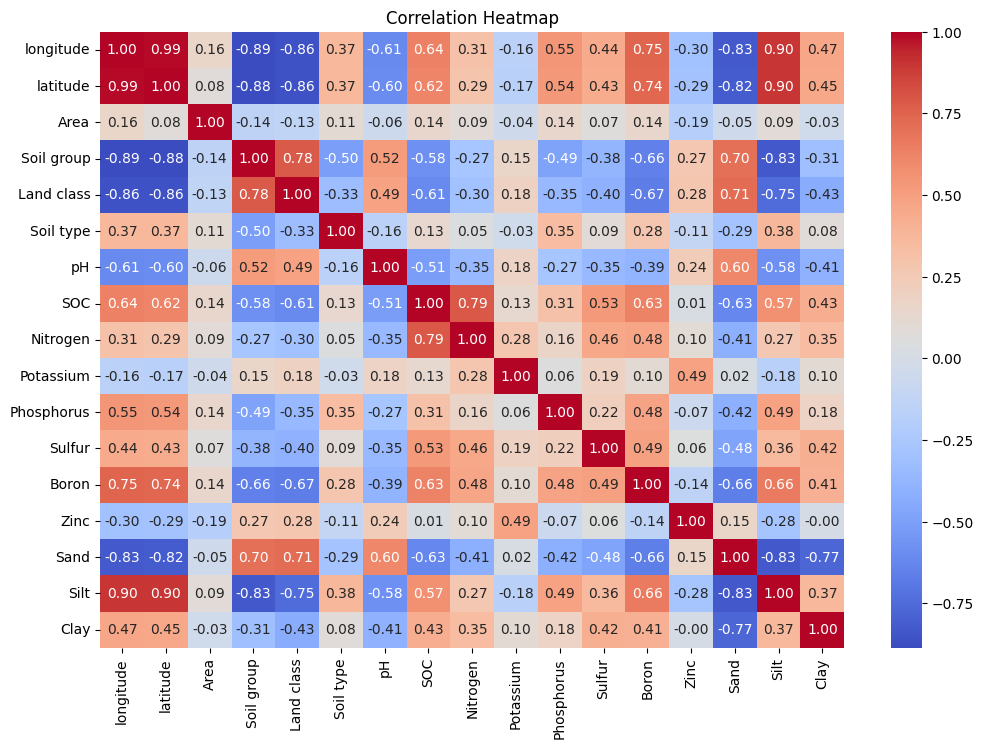

/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Best individual is: [0.14195211130312918, 0.6066875041296057, 0.05764718834002586, 0.8245955359798067, 0.40483208187556774, 0.7657351648167101, 0.1922527736466847, 0.12999107591610004, 0.46484305816427285, 0.46809925389505047, 0.9984086627816173, 0.7437050855930487, -0.09187533605711426, 0.4075791808163623, 0.6903217832045467, -0.04897603437224758]
Best R² score is: 0.6075040135311717
Final R² Score: 0.6075


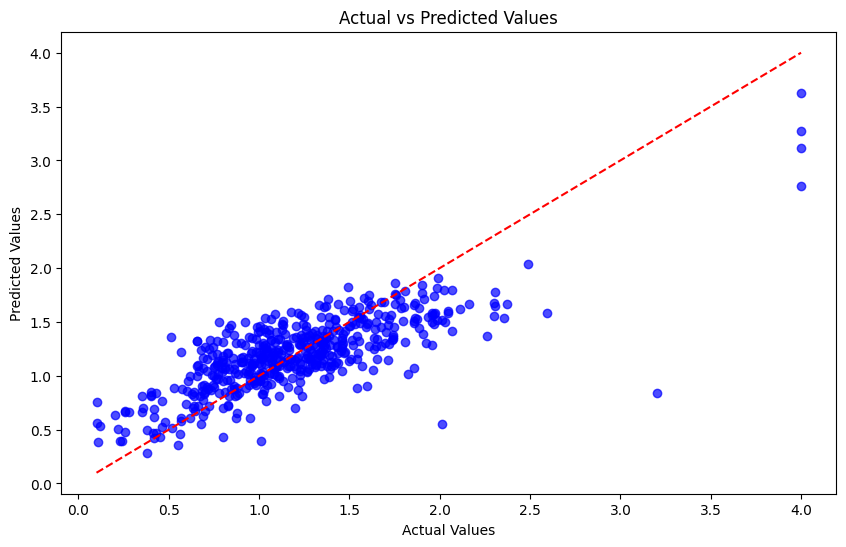

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle

# Load the dataset
file_path = '/kaggle/input/final-ipage/merged_v3.csv'
data = pd.read_csv(file_path)

# Define the target variable
target = 'Zinc'

# Separate numerical and categorical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# Remove the target from numerical columns
if target in numerical_cols:
    numerical_cols.remove(target)

# Handle missing values
data.fillna(data.median(numeric_only=True), inplace=True)

# Label encoding for categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Standardizing numerical features
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Define features (X) and target (y)
X = data.drop(columns=[target])
y = data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DEAP Genetic Algorithm setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define toolbox
toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=X_train.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_model(individual):
    weights = np.array(individual)
    X_weighted = X_train * weights
    model = RandomForestRegressor(random_state=42)
    model.fit(X_weighted, y_train)
    y_pred = model.predict(X_test * weights)
    return r2_score(y_test, y_pred),

toolbox.register("evaluate", eval_model)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run Genetic Algorithm
population = toolbox.population(n=50)
NGEN = 10
CXPB, MUTPB = 0.5, 0.2

for gen in range(NGEN):
    offspring = algorithms.varAnd(population, toolbox, cxpb=CXPB, mutpb=MUTPB)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Best individual
best_ind = tools.selBest(population, k=1)[0]
print("Best individual is:", best_ind)
print("Best R² score is:", eval_model(best_ind)[0])

# Model evaluation using the best weights
best_weights = np.array(best_ind)
X_weighted_train = X_train * best_weights
X_weighted_test = X_test * best_weights

final_model = RandomForestRegressor(random_state=42)
final_model.fit(X_weighted_train, y_train)
y_pred = final_model.predict(X_weighted_test)

r2 = r2_score(y_test, y_pred)
print(f"Final R² Score: {r2:.4f}")

# Visualization of predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values")
plt.show()
